In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.0.0+cu118


In [2]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Wed May  3 12:46:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get data
Food101 datasets

In [4]:
import requests
import zipfile
from pathlib import Path

# Set up path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_file():
    print(f"{image_path} is exist and skipping download...")
else:
    image_path.mkdir(parents=True, 
                     exist_ok=True)
    
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloding pizza_steak_sushi.zip....")
    f.write(request.content)
    
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza_steak_sushi.zip data ....")
    zip_ref.extractall(image_path)


Downloding pizza_steak_sushi.zip....
Unzipping pizza_steak_sushi.zip data ....


In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

In [6]:
!ls data/pizza_steak_sushi/test

pizza  steak  sushi


## 2. Becomming one with the data

In [7]:
import os 
def walk_through_dir(dir_path):
    
    """Walks through di_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [9]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
print(train_dir)
print(test_dir)

data/pizza_steak_sushi/train
data/pizza_steak_sushi/test


## 2.1 Visualizing and image

data/pizza_steak_sushi/train/steak/2129685.jpg
steak
Random image path : data/pizza_steak_sushi/train/steak/2129685.jpg
Image class: steak
Image height: 512
Image width: 512


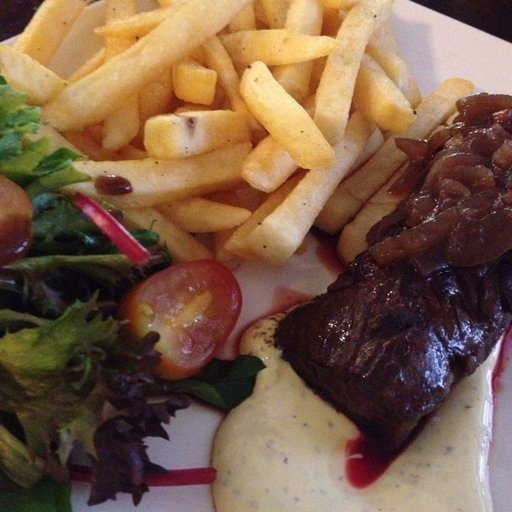

In [10]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# print(image_path_list)

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. open image 
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path : {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

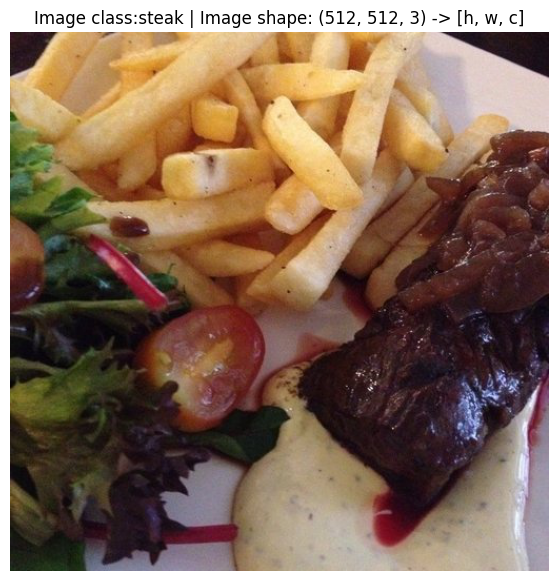

In [12]:
import numpy as np
import matplotlib.pyplot as plt


img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class:{image_class} | Image shape: {img_as_array.shape} -> [h, w, c]")
plt.axis("off")

## 3. transforming Data
1. turn data to tensor
2. Turn it into a `torh.utils.data.Dataset` and `torch.utils.data.DataLoader`


In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with `torchvision.transform`

In [14]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [20]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

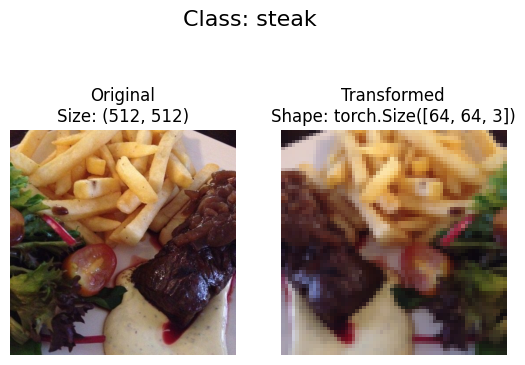

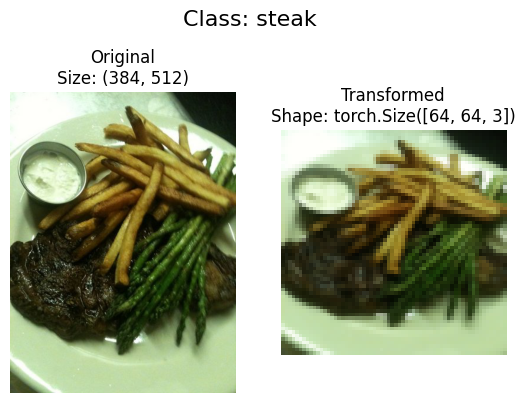

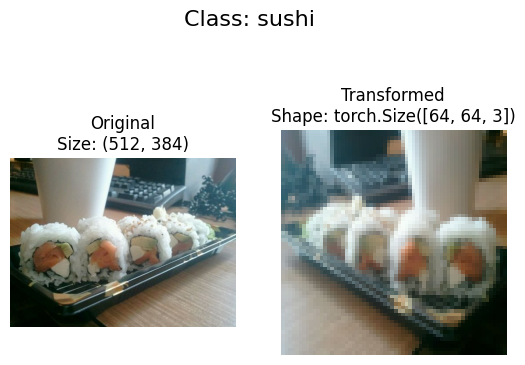

In [22]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n=3,
                            seed=42):
  """Selects random images from path and transforms it and plots them"""
  if seed: 
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")
      
      
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)
  